In [2]:
#ランタイムGPUにすべし
#google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#データ取得
import glob
import os

img_dir = './drive/MyDrive/H1-No20-286/org286/'
val_dir = './drive/MyDrive/H1-No20-286/val286/'
mask_dir = './drive/MyDrive/H1-No20-286/masked286/'

img_files = []
for i in range(3400):
  img_files.append(img_dir + str(i+1) + ".png")

val_files = []
for i in range(3400):
  val_files.append(val_dir + str(i+1) + ".png")
print('画像ファイル数:', len(img_files))
print('検証ファイル数:', len(val_files))

画像ファイル数: 3400
検証ファイル数: 3400


In [26]:
#データ確認
from PIL import Image
import cv2

im_image =Image.open(img_files[100])
im_image

NameError: ignored

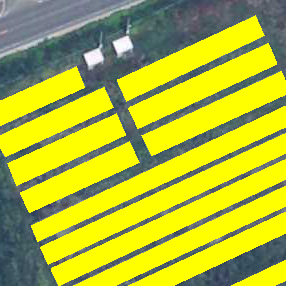

In [ ]:
val_image =Image.open(val_files[100])
val_image

In [30]:
#mask file 作成
import matplotlib.pyplot as plt
import numpy as np

for file in val_files:
  img = cv2.imread(file)
  maskBGR = cv2.inRange(img,(0,255,255),(0,255,255))
  resultBGR = cv2.bitwise_and(img,img, mask = maskBGR)
  maskBGR = 255 - maskBGR
  cv2.imwrite(file.replace("val286","masked286"),maskBGR)


In [4]:
mask_files = []
for i in range(3400):
  mask_files.append(mask_dir + str(i+1) + ".png")

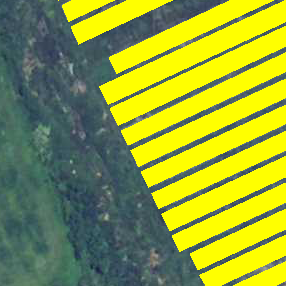

In [3]:
#mask file 確認
from PIL import Image
import cv2

im_image =Image.open(val_files[102])
im_image

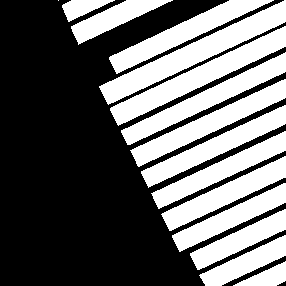

In [ ]:
mask_image =Image.open(mask_files[102])
mask_image

In [5]:
#データセット分割
from PIL import Image
train_dataset_rate = 0.7
val_dataset_rate = 0.2

# x_train_files = img_files[0:int(3400*train_dataset_rate)]
# for file in x_train_files:
#   img = Image.open(file)
#   img.save(file.replace("org286","data/train/org286"))

y_train_files = mask_files[0:int(3400*train_dataset_rate)]
for file in y_train_files:
  img = Image.open(file)
  img.save(file.replace("masked286","data/train/mask286"))

# x_val_files = img_files[int(3400*train_dataset_rate):int(3400*(val_dataset_rate+train_dataset_rate))]
# for file in x_val_files:
#   img = Image.open(file)
#   img.save(file.replace("org286","data/val/org286"))

y_val_files = mask_files[int(3400*train_dataset_rate):int(3400*(val_dataset_rate+train_dataset_rate))]
for file in y_val_files:
    img = Image.open(file)
    img.save(file.replace("masked286","data/val/mask286"))

# x_test_files = img_files[int(3400*(val_dataset_rate+train_dataset_rate)):]
# for file in x_test_files:
#     img = Image.open(file)
#     img.save(file.replace("org286","data/test/org286"))

y_test_files = mask_files[int(3400*(val_dataset_rate+train_dataset_rate)):]
for file in y_test_files:
    img = Image.open(file)
    img.save(file.replace("masked286","data/test/mask286"))

In [6]:
#GPU設定
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("GPU device name", torch.cuda.get_device_name(0))

Exception: ignored

In [7]:
#分割したデータ取得
import glob
import os

train_dir = './drive/MyDrive/H1-No20-286/data/train/'
val_dir = './drive/MyDrive/H1-No20-286/data/val/'
test_dir = './drive/MyDrive/H1-No20-286/data/test/'


x_train_files = glob.glob(train_dir + "org286/*")
y_train_files = glob.glob(train_dir + "mask286/*")

x_val_files = glob.glob(val_dir + "org286/*")
y_val_files = glob.glob(val_dir + "mask286/*")

x_test_files = glob.glob(test_dir + "org286/*")
y_test_files = glob.glob(test_dir + "mask286/*")


print("train files:",len(x_train_files))
print("val files:", len(x_val_files))
print("test files:", len(x_test_files))

train files: 2380
val files: 679
test files: 341


In [8]:
#データの作成
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset


In [18]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['solar_panel','unlabelled'] #変更

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        #print(self.class_values)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        #mask = np.array(Image.open(self.masks_fps[i]))
        #print(self.images_fps[i])
        #print(self.masks_fps[i])
        # print(mask)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        #print(masks)
        mask = np.stack(masks, axis=-1).astype('float')


        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


In [19]:
# 航空機画像とマスク画像を並べて表示させるための関数を設定
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(12, 7))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


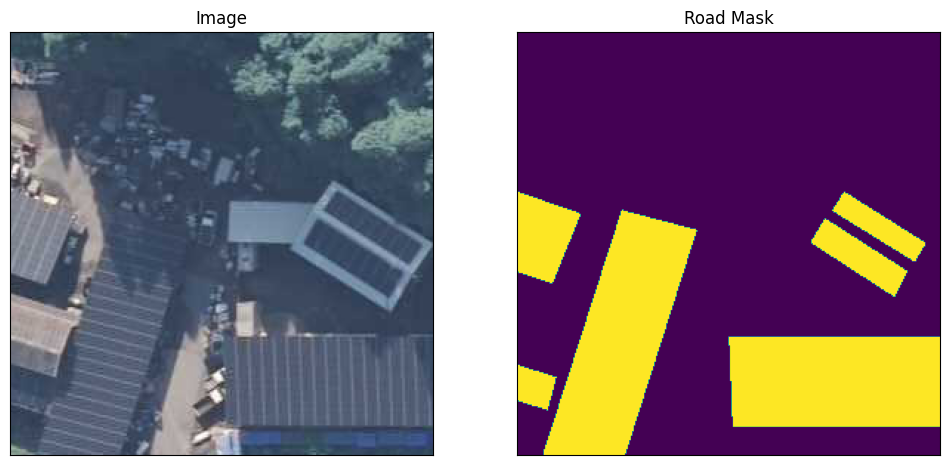

In [22]:
import cv2
import numpy as np

dataset = Dataset(train_dir + "org286", train_dir + "mask286", classes=['solar_panel'])
image, mask = dataset[11] # get some sample
visualize(
    image=image,
    road_mask=mask.squeeze(),
)




In [23]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-mfye47p4
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-mfye47p4
  Resolved https://github.com/albu/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


In [24]:
#DA
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(288, 288)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

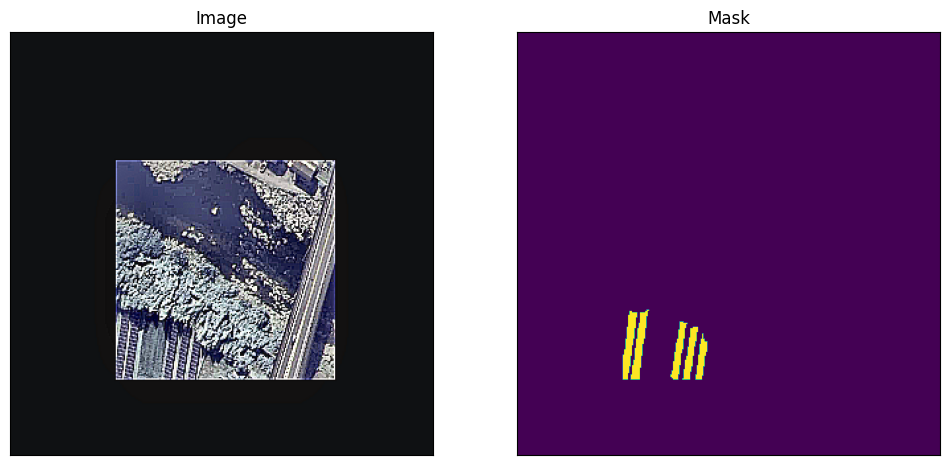

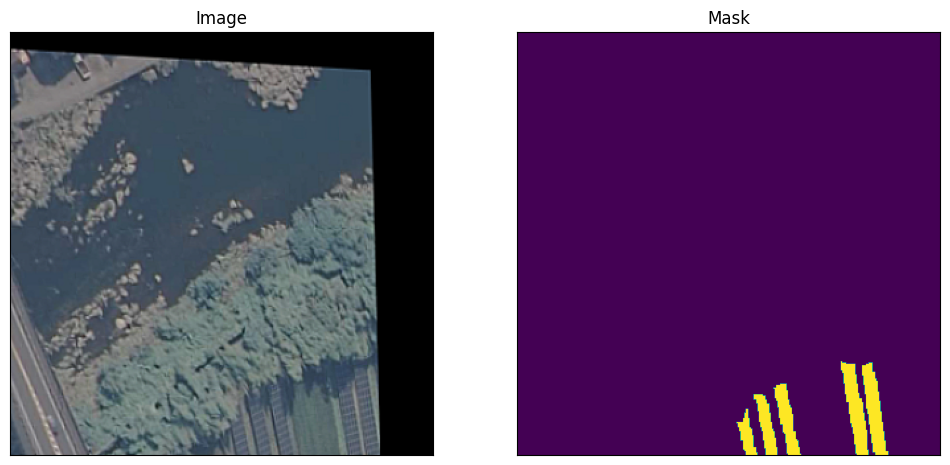

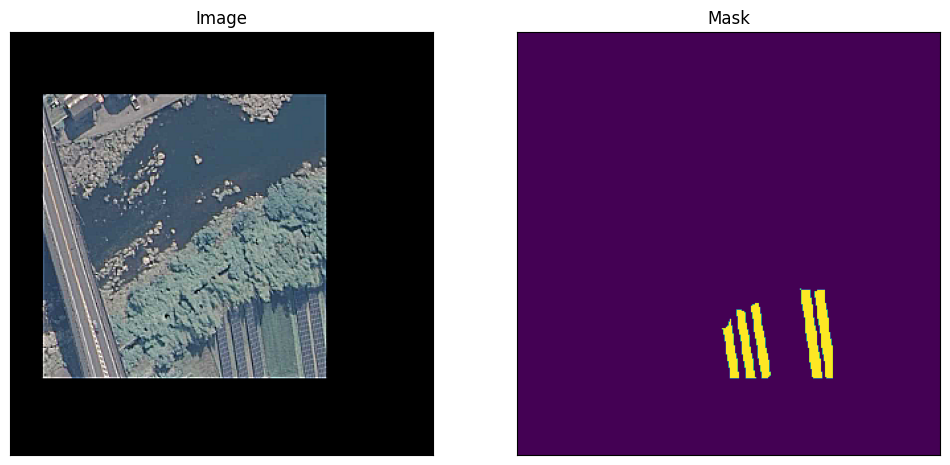

In [25]:
augmented_dataset = Dataset(
    train_dir + "org286",
    train_dir + "mask286",
    augmentation=get_training_augmentation(),
    classes=['solar_panel'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[19]
    visualize(image=image, mask=mask.squeeze(-1))

In [11]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=df58af31ebc1c344b09bfc7c904e11f743f9298ec9d99431c36fd8f83c3d8681
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=7f857fb27dd96f2e4f5632a671592e1a5f2c0ea596dae4c7368355e49db3102b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [12]:
#model構築
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar_panel']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


In [13]:
train_dataset = Dataset(
    train_dir + "org286",
    train_dir + "mask286",
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    val_dir + "org286",
    val_dir + "mask286",
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

In [14]:
from segmentation_models_pytorch import utils as smp_utils
#smp.utilsでエラーとなるため、こちらを使用

loss = smp_utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])


In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)


In [ ]:
max_score = 0


#train accurascy, train loss, val_accuracy, val_loss をグラフ化できるように設定．
x_epoch_data = []
train_dice_loss = []
train_iou_score = []
valid_dice_loss = []
valid_iou_score = []


for i in range(0, 50): #学習モデルの精度を高めたいときは、こちらの数字を大きくします。ただし、それだけ学習に時間がかかります。

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './drive/MyDrive/H1-No20-286/best_model_Unet_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 50:
        optimizer.param_groups[0]['lr'] = 5e-6
        print('Decrease decoder learning rate to 1e-6!')



Epoch: 0
valid: 100%|██████████| 679/679 [00:21<00:00, 32.29it/s, dice_loss - 0.1113, iou_score - 0.8969]
Model saved!

Epoch: 1
valid: 100%|██████████| 679/679 [00:21<00:00, 31.65it/s, dice_loss - 0.06033, iou_score - 0.9275]
Model saved!

Epoch: 2
valid: 100%|██████████| 679/679 [00:20<00:00, 33.46it/s, dice_loss - 0.05569, iou_score - 0.925]

Epoch: 3
valid: 100%|██████████| 679/679 [00:20<00:00, 32.69it/s, dice_loss - 0.04963, iou_score - 0.9248]

Epoch: 4
valid: 100%|██████████| 679/679 [00:21<00:00, 32.17it/s, dice_loss - 0.04308, iou_score - 0.9368]
Model saved!

Epoch: 5
valid: 100%|██████████| 679/679 [00:20<00:00, 33.83it/s, dice_loss - 0.04254, iou_score - 0.9328]

Epoch: 6
valid: 100%|██████████| 679/679 [00:21<00:00, 31.49it/s, dice_loss - 0.04535, iou_score - 0.9281]

Epoch: 7
valid: 100%|██████████| 679/679 [00:21<00:00, 32.19it/s, dice_loss - 0.04719, iou_score - 0.9254]

Epoch: 8
valid: 100%|██████████| 679/679 [00:20<00:00, 32.64it/s, dice_loss - 0.04244, iou_score -

In [16]:
# 学習モデルの確認
best_model = torch.load('./drive/MyDrive/H1-No20-286/best_model_Unet_resnet50.pth')

best_model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [17]:
#test
# create test dataset
test_dataset = Dataset(
    test_dir + "org286",
    test_dir + "mask286",
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)



In [18]:
logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 341/341 [01:38<00:00,  3.46it/s, dice_loss - 0.02904, iou_score - 0.9509]


In [19]:
#実際に画像を使う
test_dataset_vis = Dataset(
    test_dir+"org286", test_dir + "mask286",
    classes=CLASSES,
)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


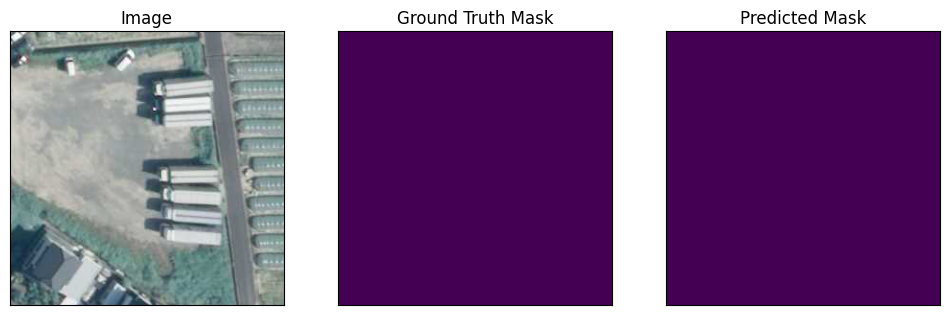

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


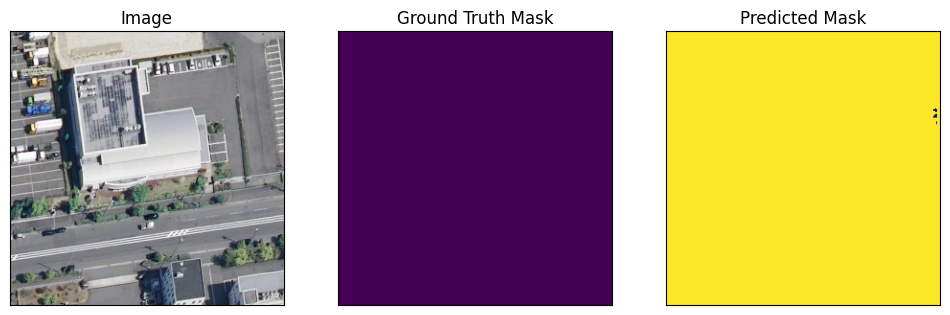

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


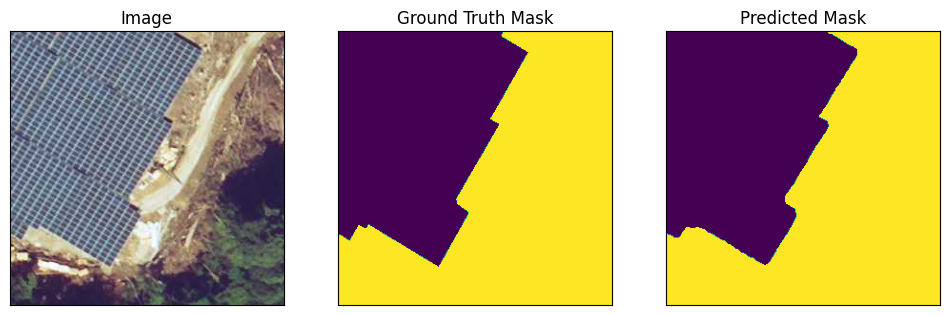

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


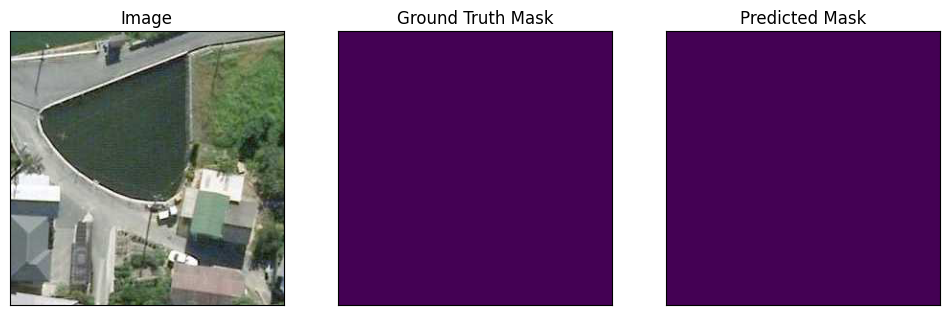

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


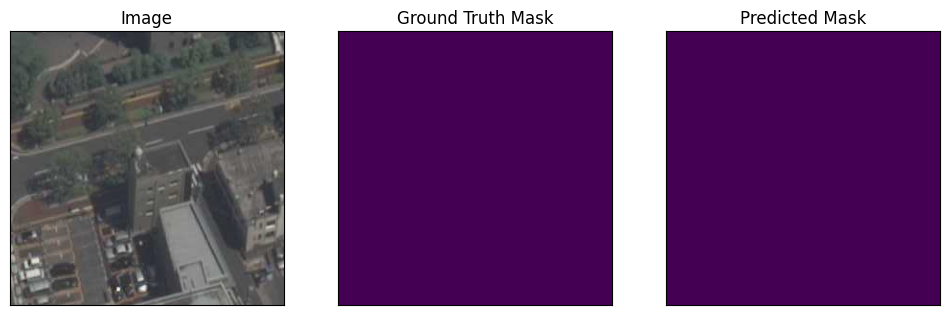

In [24]:
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    masked_image =

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )
